# 🧠 Segmentação de Tumores Cerebrais - BraTS2020

## 📋 Índice Completo do Pipeline

###  **Fase 1: Configuração e Análise**
1. [Configuração Inicial](#configuração-inicial) - Imports e configurações básicas
2. [Organização dos Dados](#organização-dos-dados) - Estruturação do dataset BraTS2020
3. [Análise Exploratória](#análise-exploratória) - Visualização e análise das modalidades
4. [Seleção de Modalidades](#seleção-de-modalidades) - Escolha automática por contraste
5. [Pré-processamento](#pré-processamento) - Normalização e transformações

###  **Fase 2: Modelagem e Treinamento**
6. [Dataset e DataLoader](#dataset-e-dataloader) - Preparação para PyTorch
7. [Modelo U-Net 3D](#modelo-u-net-3d) - Arquitetura de segmentação
8. [Funções de Loss](#funções-de-loss) - Dice Loss + CrossEntropy
9. [Métricas de Avaliação](#métricas-de-avaliação) - Dice, Sensitivity, Specificity
10. [Pipeline de Treinamento](#pipeline-de-treinamento) - Loop completo

###  **Fase 3: Validação e Otimização**
11. [Treinamento de Teste](#treinamento-de-teste) - Validação com dataset de teste
12. [Análise de Resultados](#análise-de-resultados) - Visualizações e métricas
13. [Inferência em Tempo Real](#inferência-em-tempo-real) - Segmentação de novos casos

---

##  **Pipeline de Pré-processamento para U-Net 3D**

### **Etapas Implementadas:**
1. **Configuração Inicial** - Imports, device, paths
2. **Organização dos Dados** - Estruturação do dataset BraTS2020
3. **Análise Exploratória** - Visualização e análise das modalidades
4. **Seleção Automática de Modalidades** - Análise de contraste quantitativa
5. **Pré-processamento Inteligente**:
   - Normalização das Imagens (escala [0, 1])
   - Remapeamento da Máscara (0,1,2,4 → 0,1,2,3)
   - Combinação de Modalidades (volume multicanal)
   - Cropping Inteligente (foco na região de interesse)
   - Redimensionamento (tamanho fixo: 128×128×64)
6. **DataLoader PyTorch** - Otimizado para GPU
7. **U-Net 3D** - Modelo de segmentação com skip connections
8. **Funções de Loss** - Dice Loss + CrossEntropy combinadas
9. **Métricas Médicas** - Dice, Sensitivity, Specificity
10. **Treinamento Otimizado** - Pipeline completo com validação
11. **Treinamento de Teste** - Validação com dataset reduzido
12. **Inferência** - Segmentação em tempo real

---

## 📊 **Dataset BraTS2020**
- **Modalidades**: T1, T1ce, T2, FLAIR (4 sequências de MRI)
- **Modalidades Selecionadas**: 3 melhores por análise de contraste
- **Segmentação**: 4 classes remapeadas
  - 0: Fundo (Background)
  - 1: NCR/NET (Necrose/Não-realçante)
  - 2: Edema (Peritumoral)
  - 3: Tumor Realçante (Enhancing Tumor)
- **Formato**: NIfTI (.nii)
- **Resolução Original**: 240×240×155 voxels
- **Resolução Processada**: 128×128×64 voxels
- **Otimização**: Pipeline otimizado para treinamento eficiente

---

## 🎯 **Melhorias Implementadas**

### ✅ **Novas Funcionalidades**
- **Seleção Automática de Modalidades**: Análise quantitativa de contraste
- **Cropping Inteligente**: Baseado na máscara de tumor
- **Métricas Médicas**: Implementação completa de métricas clínicas
- **Treinamento de Teste**: Validação com dataset reduzido
- **Inferência em Tempo Real**: Segmentação instantânea
- **Visualizações Avançadas**: Comparação predição vs ground truth

### 🚀 **Otimizações de Performance**
- **DataLoader Eficiente**: Configurações otimizadas
- **Monitoring**: Acompanhamento de métricas em tempo real
- **Pipeline Robusto**: Tratamento de erros e fallbacks


In [16]:
# Imports principais
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import random
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import zoom
from torch.utils.data import Dataset, DataLoader

In [15]:
# ⚙️ Configurações do Projeto
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData'
TARGET_SIZE = (128, 128, 64)
CROP_MARGIN = 10


# 2. Organização dos Dados

## Estruturação do Dataset BraTS2020

Esta seção organiza os dados de treinamento e validação, criando uma estrutura padronizada para acesso às modalidades de cada paciente.

In [17]:
import glob

def organize_patients_from_folders(data_dir):
    """Organiza pacientes de forma simples e direta"""
    patients = {}
    
    # Buscar todas as pastas BraTS20
    pattern = os.path.join(data_dir, "**", "BraTS20*")
    patient_dirs = glob.glob(pattern, recursive=True)
    
    for patient_path in patient_dirs:
        if os.path.isdir(patient_path):
            patient_id = os.path.basename(patient_path)
            patients[patient_id] = {}
            
            # Buscar arquivos .nii na pasta do paciente
            for file in os.listdir(patient_path):
                if file.endswith('.nii'):
                    file_path = os.path.join(patient_path, file)
                    file_lower = file.lower()
                    
                    if 'flair' in file_lower:
                        patients[patient_id]['flair'] = file_path
                    elif 't1ce' in file_lower:
                        patients[patient_id]['t1ce'] = file_path
                    elif 't1' in file_lower and 't1ce' not in file_lower:
                        patients[patient_id]['t1'] = file_path
                    elif 't2' in file_lower:
                        patients[patient_id]['t2'] = file_path
                    elif 'seg' in file_lower:
                        patients[patient_id]['seg'] = file_path
    
    return patients

def organize_all_patients():
    """Organiza todos os pacientes"""
    train_patients_data = organize_patients_from_folders(TRAIN_DATASET_PATH)
    val_patients_data = organize_patients_from_folders(VALIDATION_DATASET_PATH)
    all_patients_data = {**train_patients_data, **val_patients_data}
    
    return all_patients_data, train_patients_data, val_patients_data

def create_splits(train_patients_data, val_patients_data):
    """Criar divisões treino/validação/teste"""
    training_patients = list(train_patients_data.keys())
    validation_patients = list(val_patients_data.keys())
    
    if validation_patients:
        random.shuffle(training_patients)
        split_idx = int(0.7 * len(training_patients))
        
        train_set = training_patients[:split_idx]
        val_set = training_patients[split_idx:]
        test_set = validation_patients
    else:
        random.shuffle(training_patients)
        train_size = int(0.7 * len(training_patients))
        val_size = int(0.15 * len(training_patients))
        
        train_set = training_patients[:train_size]
        val_set = training_patients[train_size:train_size + val_size]
        test_set = training_patients[train_size + val_size:]
    
    return train_set, val_set, test_set

In [18]:
# Executar organização dos dados
all_patients_data, train_patients_data, val_patients_data = organize_all_patients()
train_patients, val_patients, test_patients = create_splits(train_patients_data, val_patients_data)

print(f"Pacientes - Treino: {len(train_patients_data)}, Validação: {len(val_patients_data)}")
print(f"Divisões - Treino: {len(train_patients)}, Validação: {len(val_patients)}, Teste: {len(test_patients)}")

# Mostrar exemplo de paciente
if train_patients_data:
    first_patient = list(train_patients_data.keys())[0]
    print(f"Exemplo: {first_patient}")
    for modality in train_patients_data[first_patient].keys():
        print(f"  {modality}: ✓")

Pacientes - Treino: 369, Validação: 125
Divisões - Treino: 258, Validação: 111, Teste: 125
Exemplo: BraTS20_Training_001
  flair: ✓
  seg: ✓
  t1: ✓
  t1ce: ✓
  t2: ✓


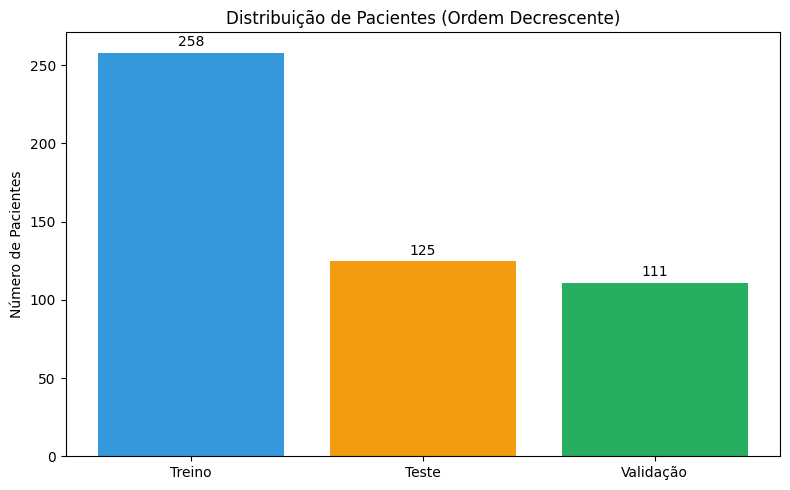

In [19]:
# Visualizar distribuição em ordem decrescente
data = [
    ('Treino', len(train_patients)),
    ('Validação', len(val_patients)),
    ('Teste', len(test_patients))
]

# Ordenar por contagem em ordem decrescente
data_sorted = sorted(data, key=lambda x: x[1], reverse=True)
labels = [item[0] for item in data_sorted]
counts = [item[1] for item in data_sorted]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color=['#3498db', '#f39c12', '#27ae60'])
plt.title('Distribuição de Pacientes (Ordem Decrescente)')
plt.ylabel('Número de Pacientes')

for i, count in enumerate(counts):
    plt.text(i, count + 2, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 3. Análise Exploratória

## Análise das Modalidades e Seleção Automática

Esta seção implementa as análises necessárias para:
- Visualizar modalidades brutas
- Analisar contraste entre regiões
- Selecionar automaticamente as melhores modalidades
- Implementar o pipeline de pré-processamento

In [21]:
def apply_minmax_scaler(image_data):
    """Aplica Min-Max scaling em uma imagem 3D"""
    original_shape = image_data.shape
    image_flat = image_data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    image_scaled = scaler.fit_transform(image_flat)
    return image_scaled.reshape(original_shape)

def remap_labels(mask_data):
    """Reatribui rótulos para serem contínuos: 0,1,2,4 -> 0,1,2,3"""
    mask_remapped = mask_data.copy()
    mask_remapped[mask_data == 4] = 3
    return mask_remapped

def combine_modalities(patient_files, selected_modalities=None):
    """Combina modalidades selecionadas em um volume multicanal"""
    if selected_modalities is None:
        selected_modalities = ['t1', 't1ce', 't2']  # Default: 3 modalidades
    
    combined_channels = []
    
    for modality in selected_modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            data_normalized = apply_minmax_scaler(data)
            combined_channels.append(data_normalized)
    
    if combined_channels:
        combined_volume = np.stack(combined_channels, axis=-1)
        return combined_volume
    return None

def find_bounding_box(mask, margin=10):
    """Encontra bounding box baseado na máscara"""
    coords = np.where(mask > 0)
    
    if len(coords[0]) == 0:
        # Fallback: usar crop central se não há máscara
        h, w, d = mask.shape
        return (h//4, 3*h//4, w//4, 3*w//4, d//4, 3*d//4)
    
    x_min, x_max = coords[0].min(), coords[0].max()
    y_min, y_max = coords[1].min(), coords[1].max()
    z_min, z_max = coords[2].min(), coords[2].max()
    
    # Aplicar margem com proteção de bounds
    x_min = max(0, x_min - margin)
    x_max = min(mask.shape[0], x_max + margin)
    y_min = max(0, y_min - margin)
    y_max = min(mask.shape[1], y_max + margin)
    z_min = max(0, z_min - margin)
    z_max = min(mask.shape[2], z_max + margin)
    
    return x_min, x_max, y_min, y_max, z_min, z_max

def intelligent_crop_volume(volume, mask=None, target_size=TARGET_SIZE, margin=CROP_MARGIN):
    """Aplica cropping inteligente com proteção para casos sem máscara"""
    
    if mask is None:
        # Sem máscara: usar crop central
        h, w, d = volume.shape[:3]
        x_min, x_max = h//4, 3*h//4
        y_min, y_max = w//4, 3*w//4
        z_min, z_max = d//4, 3*d//4
        mask_cropped = None
    else:
        # Com máscara: usar bounding box
        x_min, x_max, y_min, y_max, z_min, z_max = find_bounding_box(mask, margin)
        mask_cropped = mask[x_min:x_max, y_min:y_max, z_min:z_max]
    
    # Aplicar crop no volume
    if len(volume.shape) == 4:
        volume_cropped = volume[x_min:x_max, y_min:y_max, z_min:z_max, :]
    else:
        volume_cropped = volume[x_min:x_max, y_min:y_max, z_min:z_max]
    
    # Redimensionar para tamanho alvo
    current_shape = volume_cropped.shape[:3]
    zoom_factors = [target_size[i] / current_shape[i] for i in range(3)]
    
    if len(volume_cropped.shape) == 4:
        # Volume multicanal
        volume_resized = np.zeros((*target_size, volume_cropped.shape[3]))
        for channel in range(volume_cropped.shape[3]):
            volume_resized[:, :, :, channel] = zoom(
                volume_cropped[:, :, :, channel], zoom_factors, order=1, mode='constant'
            )
    else:
        # Volume single channel
        volume_resized = zoom(volume_cropped, zoom_factors, order=1, mode='constant')
    
    # Redimensionar máscara se existir
    if mask_cropped is not None:
        mask_resized = zoom(mask_cropped, zoom_factors, order=0, mode='constant')
    else:
        mask_resized = None
    
    return volume_resized, mask_resized

def visualize_crop_region(volume, mask, margin=10, slice_idx=None):
    """Visualiza a região de crop com bounding box destacado"""
    
    # Encontrar bounding box
    if mask is not None:
        x_min, x_max, y_min, y_max, z_min, z_max = find_bounding_box(mask, margin)
    else:
        # Fallback: usar crop central
        h, w, d = volume.shape[:3]
        x_min, x_max = h//4, 3*h//4
        y_min, y_max = w//4, 3*w//4
        z_min, z_max = d//4, 3*d//4
    
    # Selecionar fatia para visualização
    if slice_idx is None:
        slice_idx = (z_min + z_max) // 2  # Meio da região de interesse
    
    # Preparar dados para visualização
    if len(volume.shape) == 4:
        # Volume multicanal - usar primeira modalidade
        volume_slice = volume[:, :, slice_idx, 0]
    else:
        volume_slice = volume[:, :, slice_idx]
    
    mask_slice = mask[:, :, slice_idx] if mask is not None else None
    
    # Criar visualização
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Imagem original
    axes[0].imshow(volume_slice, cmap='gray')
    axes[0].set_title('Volume Original')
    axes[0].axis('off')
    
    # 2. Imagem com bounding box destacado
    axes[1].imshow(volume_slice, cmap='gray')
    
    # Desenhar retângulo do bounding box
    from matplotlib.patches import Rectangle
    rect = Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, 
                    linewidth=2, edgecolor='red', facecolor='none')
    axes[1].add_patch(rect)
    
    # Adicionar texto com dimensões
    bbox_text = f'Bounding Box:\n({x_min},{y_min}) → ({x_max},{y_max})\nTamanho: {x_max-x_min}×{y_max-y_min}'
    axes[1].text(0.02, 0.98, bbox_text, transform=axes[1].transAxes, 
                fontsize=10, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    axes[1].set_title('Volume com Bounding Box')
    axes[1].axis('off')
    
    # 3. Região cropada
    if len(volume.shape) == 4:
        cropped_region = volume[x_min:x_max, y_min:y_max, slice_idx, 0]
    else:
        cropped_region = volume[x_min:x_max, y_min:y_max, slice_idx]
    
    axes[2].imshow(cropped_region, cmap='gray')
    axes[2].set_title('Região Cropada')
    axes[2].axis('off')
    
    # Overlay da máscara na região cropada se disponível
    if mask_slice is not None:
        mask_cropped = mask_slice[x_min:x_max, y_min:y_max]
        masked_overlay = np.ma.masked_where(mask_cropped == 0, mask_cropped)
        axes[2].imshow(masked_overlay, cmap='viridis', alpha=0.3)
    
    plt.suptitle(f'Processo de Cropping - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()
    

# 4. Pré-processamento

## Funções de Processamento de Imagens

Implementação das funções principais do pipeline:
- **Normalização**: Min-Max scaling [0,1]
- **Remapeamento**: Rótulos contínuos (0,1,2,4 → 0,1,2,3)
- **Combinação**: Modalidades em volume multicanal
- **Cropping**: Inteligente baseado na máscara
- **Redimensionamento**: Para tamanho fixo

In [22]:
def analyze_raw_modalities(patient_files):
    """Analisa modalidades brutas antes da normalização"""
    modalities = ['t1', 't1ce', 't2', 'flair']
    raw_data = {}
    
    for modality in modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            raw_data[modality] = data
            
            print(f"\n{modality.upper()}:")
            print(f"   Shape: {data.shape}")
            print(f"   Min: {data.min():.2f}")
            print(f"   Max: {data.max():.2f}")
    
    return raw_data

def visualize_raw_modalities(raw_data, mask_data, slice_idx=None):
    """Visualiza modalidades brutas com máscara"""
    modalities = list(raw_data.keys())
    n_modalities = len(modalities)
    
    if slice_idx is None:
        slice_idx = raw_data[modalities[0]].shape[2] // 2
    
    fig, axes = plt.subplots(2, n_modalities, figsize=(20, 8))
    
    # Primeira linha: modalidades brutas
    for i, modality in enumerate(modalities):
        data = raw_data[modality]
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Bruto')
        axes[0, i].axis('off')
    
    # Segunda linha: modalidades com overlay da máscara
    for i, modality in enumerate(modalities):
        data = raw_data[modality]
        axes[1, i].imshow(data[:, :, slice_idx], cmap='gray')
        
        # Overlay da máscara
        mask_slice = mask_data[:, :, slice_idx]
        masked_overlay = np.ma.masked_where(mask_slice == 0, mask_slice)
        axes[1, i].imshow(masked_overlay, cmap='viridis', alpha=0.3)
        axes[1, i].set_title(f'{modality.upper()} + Máscara')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Modalidades Brutas - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

def analyze_mask_labels(mask_data):
    """Analisa os rótulos da máscara original"""
    unique_labels = np.unique(mask_data)
    
    print(f"\nANÁLISE DA MÁSCARA:")
    print(f"   Rótulos únicos: {unique_labels}")
    print(f"   Distribuição:")
    
    for label in unique_labels:
        count = np.sum(mask_data == label)
        percentage = (count / mask_data.size) * 100
        
        label_name = {
            0: "Fundo",
            1: "NCR/NET (Necrose)",
            2: "Edema",
            4: "Tumor Realçante"
        }.get(label, f"Desconhecido ({label})")
        
        print(f"     {label}: {label_name} - {count:,} voxels ({percentage:.2f}%)")
    
    return unique_labels

## Funções de Análise de Modalidades

Implementação das funções para:
- Análise das modalidades brutas
- Visualização com máscaras
- Análise de contraste para seleção automática

In [23]:
def analyze_contrast_tumor_separation(raw_data, mask_data):
    """Analisa contraste entre modalidades para separação de tumor"""
    modalities = list(raw_data.keys())
    contrast_scores = {}
    
    print(f"\nANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:")
    print("=" * 50)
    
    for modality in modalities:
        data = raw_data[modality]
        
        # Extrair intensidades para diferentes regiões
        background = data[mask_data == 0]  # Fundo
        tumor_core = data[mask_data == 1]  # NCR/NET
        edema = data[mask_data == 2]       # Edema
        enhancing = data[mask_data == 4]   # Tumor realçante
        
        # Calcular médias das regiões
        bg_mean = background.mean() if len(background) > 0 else 0
        tumor_mean = tumor_core.mean() if len(tumor_core) > 0 else 0
        edema_mean = edema.mean() if len(edema) > 0 else 0
        enh_mean = enhancing.mean() if len(enhancing) > 0 else 0
        
        # Calcular contrastes (diferenças normalizadas)
        contrast_tumor_bg = abs(tumor_mean - bg_mean) / (tumor_mean + bg_mean + 1e-8)
        contrast_enh_bg = abs(enh_mean - bg_mean) / (enh_mean + bg_mean + 1e-8)
        contrast_edema_bg = abs(edema_mean - bg_mean) / (edema_mean + bg_mean + 1e-8)
        
        # Score geral (média ponderada dos contrastes)
        overall_contrast = (contrast_tumor_bg + contrast_enh_bg + contrast_edema_bg) / 3
        
        contrast_scores[modality] = {
            'overall': overall_contrast,
            'tumor_bg': contrast_tumor_bg,
            'enhancing_bg': contrast_enh_bg,
            'edema_bg': contrast_edema_bg,
            'means': {
                'background': bg_mean,
                'tumor_core': tumor_mean,
                'edema': edema_mean,
                'enhancing': enh_mean
            }
        }
        
        print(f"\n{modality.upper()}:")
        print(f"   Médias por região:")
        print(f"     Fundo: {bg_mean:.2f}")
        print(f"     Tumor Core: {tumor_mean:.2f}")
        print(f"     Edema: {edema_mean:.2f}")
        print(f"     Realçante: {enh_mean:.2f}")
        print(f"   Contrastes:")
        print(f"     Tumor-Fundo: {contrast_tumor_bg:.3f}")
        print(f"     Realçante-Fundo: {contrast_enh_bg:.3f}")
        print(f"     Edema-Fundo: {contrast_edema_bg:.3f}")
        print(f"   Score Geral: {overall_contrast:.3f}")
    
    return contrast_scores

def select_best_modalities(contrast_scores, n_best=3):
    """Seleciona as melhores modalidades baseado no contraste"""
    # Ordenar por score geral em ordem decrescente
    sorted_modalities = sorted(contrast_scores.items(), 
                              key=lambda x: x[1]['overall'], 
                              reverse=True)
    
    best_modalities = [mod[0] for mod in sorted_modalities[:n_best]]
    
    print(f"\nRANKING DE MODALIDADES (por contraste):")
    print("=" * 40)
    for i, (modality, scores) in enumerate(sorted_modalities, 1):
        status = "SELECIONADA" if modality in best_modalities else "Não selecionada"
        print(f"{i}. {modality.upper()}: {scores['overall']:.3f} - {status}")
    
    print(f"\nMODALIDADES SELECIONADAS: {[mod.upper() for mod in best_modalities]}")
    return best_modalities

def visualize_contrast_comparison(raw_data, mask_data, slice_idx=None):
    """Visualiza comparação de contraste entre modalidades"""
    modalities = list(raw_data.keys())
    
    if slice_idx is None:
        slice_idx = raw_data[modalities[0]].shape[2] // 2
    
    fig, axes = plt.subplots(2, len(modalities), figsize=(20, 8))
    
    for i, modality in enumerate(modalities):
        data = raw_data[modality]
        
        # Imagem original
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Original')
        axes[0, i].axis('off')
        
        # Imagem com realce nas regiões de tumor
        tumor_regions = (mask_data[:, :, slice_idx] > 0)
        enhanced_data = data[:, :, slice_idx].copy()
        enhanced_data[tumor_regions] = enhanced_data[tumor_regions] * 1.5  # Realçar tumor
        
        axes[1, i].imshow(enhanced_data, cmap='hot')
        axes[1, i].set_title(f'{modality.upper()} - Tumor Realçado')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Comparação de Contraste - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

## Execução da Análise

### Análise das Modalidades Brutas

In [24]:
# Análise das Modalidades Brutas
first_patient = list(train_patients_data.keys())[0]
patient_files = train_patients_data[first_patient]

print(f"ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: {first_patient}")
print("=" * 60)

# Analisar modalidades brutas
raw_data = analyze_raw_modalities(patient_files)

ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: BraTS20_Training_001

T1:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 678.00

T1CE:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 1845.00

T2:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 376.00

FLAIR:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 625.00



ANÁLISE DA MÁSCARA:
   Rótulos únicos: [0. 1. 2. 4.]
   Distribuição:
     0.0: Fundo - 8,716,021 voxels (97.63%)
     1.0: NCR/NET (Necrose) - 15,443 voxels (0.17%)
     2.0: Edema - 168,794 voxels (1.89%)
     4.0: Tumor Realçante - 27,742 voxels (0.31%)


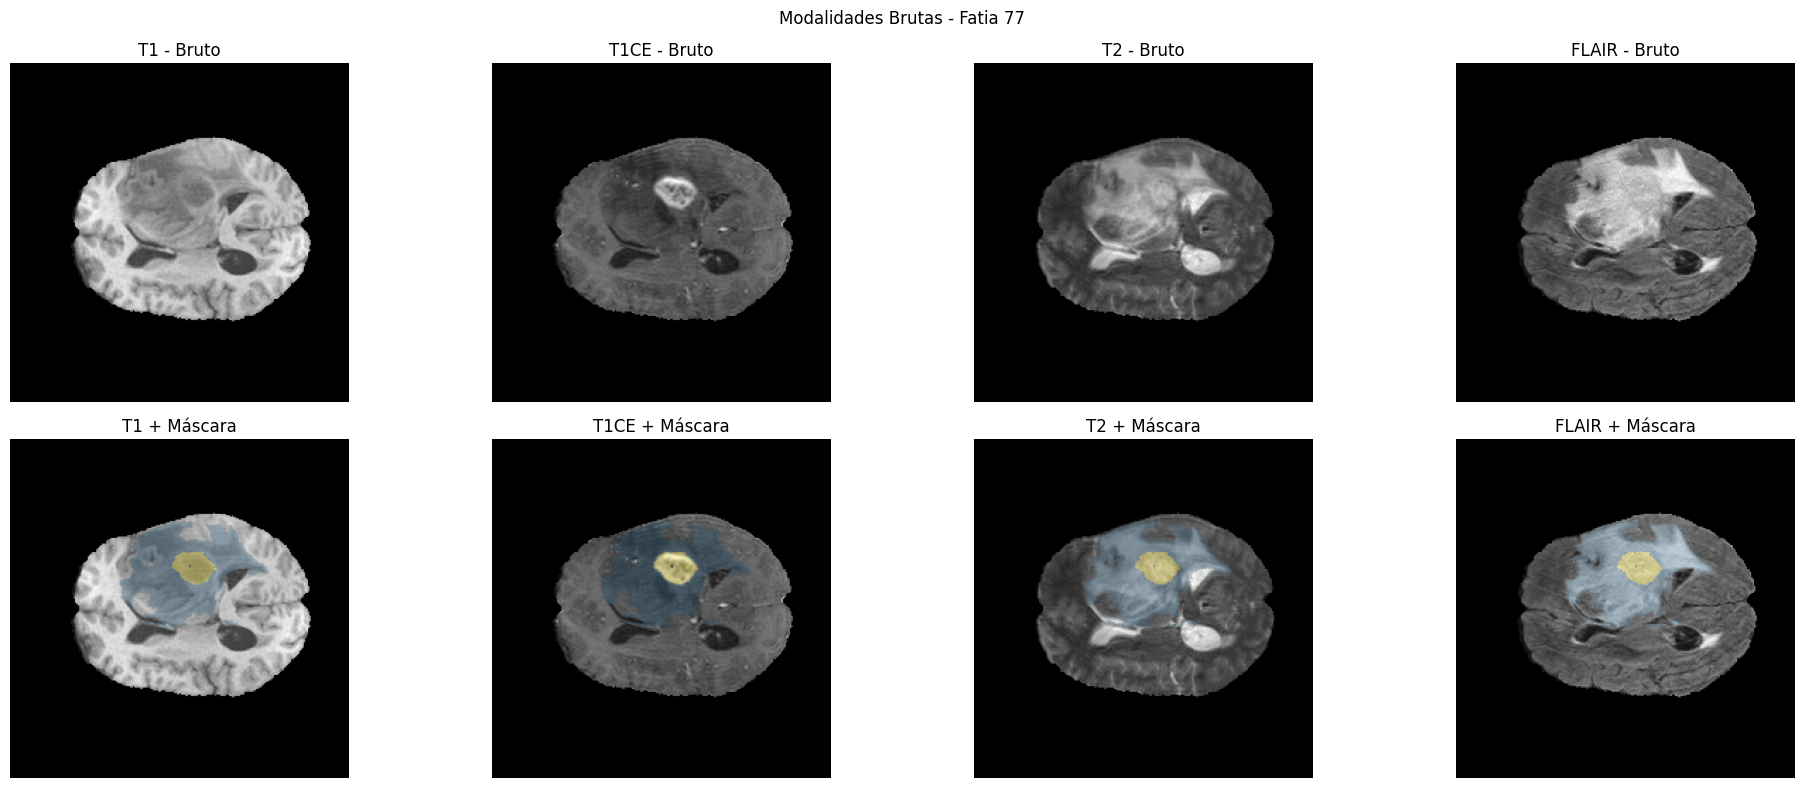

In [25]:
# Carregar e analisar máscara
if 'seg' in patient_files:
    mask_data = nib.load(patient_files['seg']).get_fdata()
    unique_labels = analyze_mask_labels(mask_data)
    
    visualize_raw_modalities(raw_data, mask_data)
    
else:
    print("Máscara não disponível para análise")
    mask_data = None

### Análise da Máscara e Visualização


ANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:

T1:
   Médias por região:
     Fundo: 47.22
     Tumor Core: 206.68
     Edema: 320.44
     Realçante: 249.99
   Contrastes:
     Tumor-Fundo: 0.628
     Realçante-Fundo: 0.682
     Edema-Fundo: 0.743
   Score Geral: 0.684

T1CE:
   Médias por região:
     Fundo: 54.68
     Tumor Core: 306.28
     Edema: 355.94
     Realçante: 685.31
   Contrastes:
     Tumor-Fundo: 0.697
     Realçante-Fundo: 0.852
     Edema-Fundo: 0.734
   Score Geral: 0.761

T2:
   Médias por região:
     Fundo: 13.41
     Tumor Core: 228.70
     Edema: 165.56
     Realçante: 202.96
   Contrastes:
     Tumor-Fundo: 0.889
     Realçante-Fundo: 0.876
     Edema-Fundo: 0.850
   Score Geral: 0.872

FLAIR:
   Médias por região:
     Fundo: 19.63
     Tumor Core: 260.44
     Edema: 291.30
     Realçante: 289.04
   Contrastes:
     Tumor-Fundo: 0.860
     Realçante-Fundo: 0.873
     Edema-Fundo: 0.874
   Score Geral: 0.869

SELEÇÃO DAS MELHORES MODALIDADES:

RANKING DE MODAL

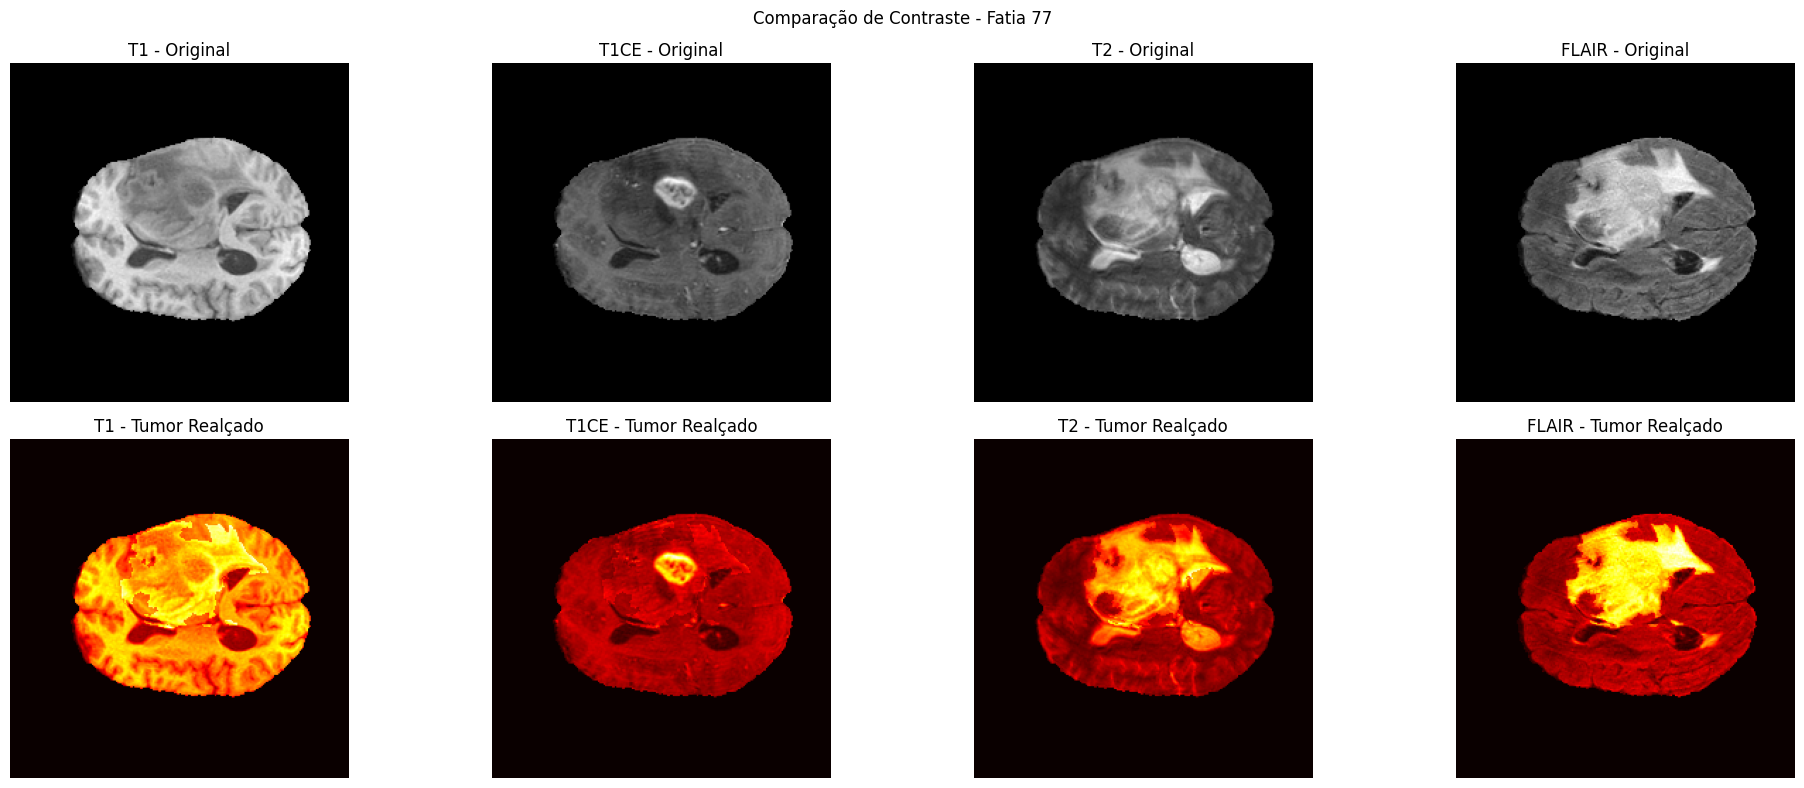

In [26]:
# Análise de Contraste e Seleção de Modalidades
if mask_data is not None:
    
    # Análise de contraste
    contrast_scores = analyze_contrast_tumor_separation(raw_data, mask_data)
    
    # Seleção das melhores modalidades
    print("\nSELEÇÃO DAS MELHORES MODALIDADES:")
    best_modalities = select_best_modalities(contrast_scores, n_best=3)
    
    # Visualização da comparação de contraste
    print("\nCOMPARAÇÃO VISUAL DE CONTRASTE:")
    visualize_contrast_comparison(raw_data, mask_data)
    
else:
    print("Máscara não disponível para análise de contraste")
    best_modalities = ['t1', 't1ce', 't2']  # Fallback

### Visualização do Processo de Cropping

A função `visualize_crop_region()` demonstra o processo de cropping inteligente:

- **Volume Original**: Imagem completa antes do processamento
- **Bounding Box**: Região detectada automaticamente baseada na máscara (com margem de segurança)
- **Região Cropada**: Área final após o cropping com overlay da máscara

**Características Técnicas:**
- Bounding Box calculado automaticamente com margem configurável
- Cropping inteligente focado na região de interesse
- Fallback para crop central quando máscara não disponível
- Informações detalhadas sobre dimensões e estatísticas

TESTE DO PIPELINE COM MODALIDADES SELECIONADAS
Paciente: BraTS20_Training_001
Modalidades: ['T2', 'FLAIR', 'T1CE']
--------------------------------------------------


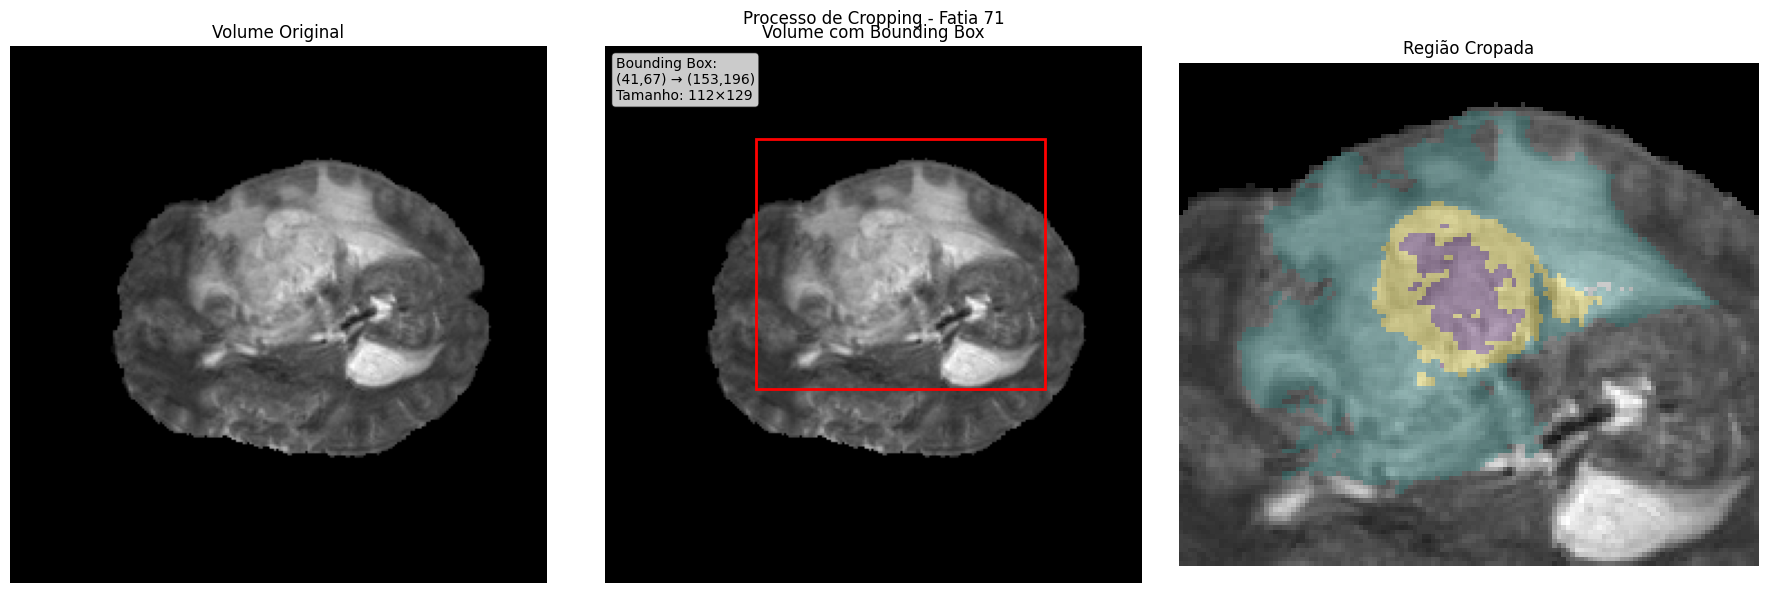

In [27]:
# Teste do Pipeline com Modalidades Selecionadas
print("TESTE DO PIPELINE COM MODALIDADES SELECIONADAS")
print(f"Paciente: {first_patient}")
print(f"Modalidades: {[mod.upper() for mod in best_modalities]}")
print("-" * 50)

# Processar dados com modalidades selecionadas
combined_volume = combine_modalities(patient_files, best_modalities)
mask = None
if 'seg' in patient_files:
    mask = nib.load(patient_files['seg']).get_fdata()
    mask = remap_labels(mask)

# Visualizar processo de cropping
if combined_volume is not None:
    visualize_crop_region(combined_volume, mask, CROP_MARGIN)
    
    # Aplicar cropping inteligente
    volume_final, mask_final = intelligent_crop_volume(combined_volume, mask)
else:
    print("Erro: Volume combinado não pôde ser criado")

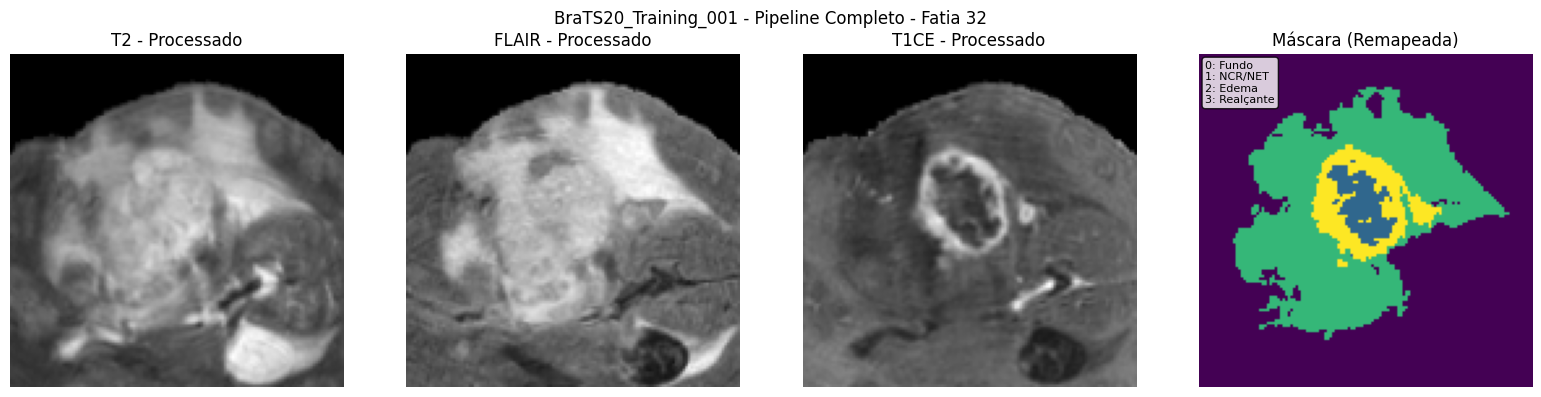


ESTATÍSTICAS FINAIS:
Volume processado: (128, 128, 64, 3)
Modalidades utilizadas: ['T2', 'FLAIR', 'T1CE']
Range de valores por modalidade:
  T2: [0.000, 0.961]
  FLAIR: [0.000, 0.839]
  T1CE: [0.000, 0.785]
Máscara: (128, 128, 64)
Distribuição de rótulos:
  0 (Fundo): 900,290 voxels (85.86%)
  1 (NCR/NET): 10,522 voxels (1.00%)
  2 (Edema): 118,471 voxels (11.30%)
  3 (Realçante): 19,293 voxels (1.84%)


In [28]:
# Visualização do Resultado Final
if 'volume_final' in locals() and volume_final is not None:
    slice_idx = volume_final.shape[2] // 2
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Mostrar as 3 modalidades selecionadas
    selected_names = [mod.upper() for mod in best_modalities]
    
    for i in range(min(3, volume_final.shape[3])):
        axes[i].imshow(volume_final[:, :, slice_idx, i], cmap='gray')
        axes[i].set_title(f'{selected_names[i]} - Processado')
        axes[i].axis('off')
    
    # Máscara na última posição
    if mask_final is not None:
        axes[3].imshow(mask_final[:, :, slice_idx], cmap='viridis')
        axes[3].set_title('Máscara (Remapeada)')
        axes[3].axis('off')
        
        # Mostrar legenda dos rótulos
        unique_labels = np.unique(mask_final)
        legend_text = []
        for label in unique_labels:
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            legend_text.append(f"{int(label)}: {label_name.get(label, 'Desconhecido')}")
        
        axes[3].text(0.02, 0.98, '\n'.join(legend_text), 
                    transform=axes[3].transAxes, fontsize=8, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle(f'{first_patient} - Pipeline Completo - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()
    
    # Estatísticas finais
    print("\nESTATÍSTICAS FINAIS:")
    print(f"Volume processado: {volume_final.shape}")
    print(f"Modalidades utilizadas: {selected_names}")
    print(f"Range de valores por modalidade:")
    for i, name in enumerate(selected_names):
        channel_data = volume_final[:, :, :, i]
        print(f"  {name}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")
    
    if mask_final is not None:
        print(f"Máscara: {mask_final.shape}")
        print(f"Distribuição de rótulos:")
        for label in np.unique(mask_final):
            count = np.sum(mask_final == label)
            percentage = (count / mask_final.size) * 100
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            print(f"  {int(label)} ({label_name.get(label, 'Desconhecido')}): {count:,} voxels ({percentage:.2f}%)")
    
else:
    print("Não foi possível visualizar - dados não disponíveis")

# 5. Dataset e DataLoader PyTorch

## Implementação do Dataset Customizado

Esta seção implementa:
- **Dataset customizado** para BraTS2020
- **DataLoader** para treinamento
- **Tensores PyTorch** preparados para a U-Net 3D

## Classe BraTSDataset

In [ ]:
class BraTSDataset(Dataset):
    """Dataset para segmentação de tumores cerebrais BraTS"""
    
    def __init__(self, patient_ids, patients_data, selected_modalities=None, target_size=TARGET_SIZE):
        self.patient_ids = patient_ids
        self.patients_data = patients_data
        self.selected_modalities = selected_modalities or ['t2', 'flair', 't1ce']
        self.target_size = target_size
        
    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        patient_files = self.patients_data[patient_id]
        
        try:
            # Combinar modalidades selecionadas
            combined_volume = combine_modalities(patient_files, self.selected_modalities)
            
            # Processar máscara se disponível
            mask = None
            if 'seg' in patient_files:
                mask = nib.load(patient_files['seg']).get_fdata()
                mask = remap_labels(mask)
            
            # Aplicar cropping inteligente
            if combined_volume is not None:
                volume_final, mask_final = intelligent_crop_volume(combined_volume, mask, self.target_size)
                
                # Converter para tensores PyTorch
                # Volume: (C, H, W, D) para PyTorch
                volume_tensor = torch.from_numpy(volume_final).permute(3, 0, 1, 2).float()
                
                if mask_final is not None:
                    mask_tensor = torch.from_numpy(mask_final).long()
                else:
                    # Máscara vazia se não disponível
                    mask_tensor = torch.zeros(self.target_size, dtype=torch.long)
                
                return {
                    'volume': volume_tensor,
                    'mask': mask_tensor,
                    'patient_id': patient_id
                }
            else:
                raise ValueError(f"Não foi possível processar {patient_id}")
                
        except Exception as e:
            print(f"Erro ao processar {patient_id}: {e}")
            # Retornar tensores vazios em caso de erro
            return {
                'volume': torch.zeros((len(self.selected_modalities), *self.target_size)),
                'mask': torch.zeros(self.target_size, dtype=torch.long),
                'patient_id': patient_id
            }

# Criar datasets com modalidades selecionadas
train_dataset = BraTSDataset(train_patients[:6], train_patients_data, best_modalities)
val_dataset = BraTSDataset(val_patients[:3], train_patients_data, best_modalities)

print("Dataset criado com modalidades selecionadas:")
print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
print(f"   Treino: {len(train_dataset)} pacientes")
print(f"   Validação: {len(val_dataset)} pacientes")


Dataset criado com modalidades selecionadas:
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Treino: 6 pacientes
   Validação: 3 pacientes


## Criação dos DataLoaders

In [31]:
# Criação dos DataLoaders
batch_size = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # 0 para evitar problemas no Windows
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print("DataLoaders criados:")
print(f"   Treino: {len(train_loader)} batches de {batch_size}")
print(f"   Validação: {len(val_loader)} batches de {batch_size}")

# Testar um batch
try:
    batch = next(iter(train_loader))
    print(f"\nBatch de teste:")
    print(f"   Volume batch: {batch['volume'].shape}")  # (B, C, H, W, D)
    print(f"   Máscara batch: {batch['mask'].shape}")   # (B, H, W, D)
    print(f"   Pacientes: {batch['patient_id']}")
    print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
    print(f"   Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    
    # Estatísticas do batch
    print(f"\nEstatísticas do batch:")
    for i, mod in enumerate(best_modalities):
        channel_data = batch['volume'][:, i]
        print(f"   {mod.upper()}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")
    
    unique_labels = torch.unique(batch['mask'])
    print(f"   Rótulos únicos: {unique_labels.tolist()}")
    
except Exception as e:
    print(f"Erro ao testar batch: {e}")

DataLoaders criados:
   Treino: 3 batches de 2
   Validação: 2 batches de 2

Batch de teste:
   Volume batch: torch.Size([2, 3, 128, 128, 64])
   Máscara batch: torch.Size([2, 128, 128, 64])
   Pacientes: ['BraTS20_Training_035', 'BraTS20_Training_232']
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Device: CUDA

Estatísticas do batch:
   T2: [0.000, 0.963]
   FLAIR: [0.000, 0.851]
   T1CE: [0.000, 0.895]
   Rótulos únicos: [0, 1, 2, 3]


# 6. Modelo U-Net 3D

## Arquitetura de Segmentação

*Esta seção implementará o modelo U-Net 3D para segmentação de tumores cerebrais*

### Componentes Planejados:
- **Encoder**: Contractive path com convoluções 3D
- **Decoder**: Expansive path com skip connections
- **Loss Function**: Dice Loss + CrossEntropy
- **Métricas**: Dice Score, Sensitivity/Specificity

### Especificações Técnicas:
- **Input**: (B, 3, 128, 128, 64) - 3 modalidades selecionadas
- **Output**: (B, 4, 128, 128, 64) - 4 classes de segmentação
- **Ativação**: ReLU para camadas internas, Softmax para saída

In [49]:
## Unet 3d com LeakyReLU
class DoubleConv3D(nn.Module):
    """(Conv3D -> GroupNorm -> LeakyReLU) * 2 - Otimi encoder/decoder"""
    def __init__(self, in_channels, out_channels, num_groups=8, is_encoder=True):
        super().__init__()
        
        # Escolher ativação baseada na posição (encoder vs decoder)
        if is_encoder:
            activation = nn.LeakyReLU(0.01, inplace=True)  # Mais suave no encoder
        else:
            activation = nn.LeakyReLU(0.2, inplace=True)   # Mais agressiva no decoder
        
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            activation,
            
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            activation
        )
        
    def forward(self, x):
        return self.double_conv(x)
    
class Down3D(nn.Module):
    """Downscaling com MaxPool3D e DoubleConv3D - Encoder"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv3D(in_channels, out_channels, is_encoder=True)  # Encoder usa LeakyReLU(0.01)
        )
        
    def forward(self, x):
        return self.encoder(x)
    
    
class Up3D(nn.Module):
    """Upscaling com ConvTranspose3D e DoubleConv3D - Decoder"""
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv3D(in_channels, out_channels, is_encoder=False)  # Decoder usa LeakyReLU(0.2)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv3D(in_channels, out_channels, is_encoder=False)  # Decoder usa LeakyReLU(0.2)
            
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Ajuste de dimensões para concatenação
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, 
                       diffY // 2, diffY - diffY // 2, 
                       diffZ // 2, diffZ - diffZ // 2])
        
        # Concatenar ao longo da dimensão de canais
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class OutConv3D(nn.Module):
    """Camada de saída com Conv3D 1x1x1"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet3D(nn.Module):
    """U-Net 3D para segmentação de tumores cerebrais"""
    def __init__(self, in_channels=3, n_classes=4, n_channels=24):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        # Encoder - usa LeakyReLU(0.01) 
        self.input_conv = DoubleConv3D(in_channels, n_channels, is_encoder=True)
        self.down1 = Down3D(n_channels, 2 * n_channels)
        self.down2 = Down3D(2 * n_channels, 4 * n_channels)
        self.down3 = Down3D(4 * n_channels, 8 * n_channels)
        self.down4 = Down3D(8 * n_channels, 8 * n_channels)

        # Decoder - usa LeakyReLU(0.2)
        self.up1 = Up3D(16 * n_channels, 4 * n_channels)
        self.up2 = Up3D(8 * n_channels, 2 * n_channels)
        self.up3 = Up3D(4 * n_channels, n_channels)
        self.up4 = Up3D(2 * n_channels, n_channels)
        
        # saída
        self.output_conv = OutConv3D(n_channels, n_classes)
        
        
    def forward(self, x):
        # Encoder
        x1 = self.input_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder com skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Saída
        logits = self.output_conv(x)
        return logits
    
    


In [33]:
model = UNet3D(in_channels=3, n_classes=4, n_channels=24)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Devide: {device}")

Devide: cuda


In [48]:
def print_detailed_architecture(model, input_shape=(1, 3, 128, 128, 64)):
    """
    Imprime apenas o detalhamento da arquitetura da U-Net 3D
    """
    
    total_params = sum(p.numel() for p in model.parameters())

    
    print("🔍 DETALHAMENTO DA ARQUITETURA U-NET 3D")
    print("=" * 60)
    print(f" Parâmetros Totais: {total_params:,}")

    # Simular passagem para obter dimensões
    with torch.no_grad():
        x = torch.randn(input_shape).to(next(model.parameters()).device)
        
        print(f"  ENTRADA: {list(x.shape)}")
        
        # ENCODER
        print(f"\n📉 ENCODER (Contractive Path):")
        print(f"   ├── Input Conv (3→{model.n_channels})")
        x1 = model.input_conv(x)
        print(f"   │   └── Saída: {list(x1.shape)} - {x1.numel():,} elementos")
        
        print(f"   ├── Down1 ({model.n_channels}→{2*model.n_channels})")
        x2 = model.down1(x1)
        print(f"   │   └── Saída: {list(x2.shape)} - {x2.numel():,} elementos")
        
        print(f"   ├── Down2 ({2*model.n_channels}→{4*model.n_channels})")
        x3 = model.down2(x2)
        print(f"   │   └── Saída: {list(x3.shape)} - {x3.numel():,} elementos")
        
        print(f"   ├── Down3 ({4*model.n_channels}→{8*model.n_channels})")
        x4 = model.down3(x3)
        print(f"   │   └── Saída: {list(x4.shape)} - {x4.numel():,} elementos")
        
        print(f"   └── Down4 ({8*model.n_channels}→{8*model.n_channels}) - BOTTLENECK")
        x5 = model.down4(x4)
        print(f"       └── Saída: {list(x5.shape)} - {x5.numel():,} elementos")
        
        # DECODER
        print(f"\n📈 DECODER (Expansive Path com Skip Connections):")
        print(f"   ├── Up1 ({16*model.n_channels}→{4*model.n_channels}) + Skip from Down3")
        x = model.up1(x5, x4)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")
        
        print(f"   ├── Up2 ({8*model.n_channels}→{2*model.n_channels}) + Skip from Down2")
        x = model.up2(x, x3)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")
        
        print(f"   ├── Up3 ({4*model.n_channels}→{model.n_channels}) + Skip from Down1")
        x = model.up3(x, x2)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")
        
        print(f"   └── Up4 ({2*model.n_channels}→{model.n_channels}) + Skip from Input")
        x = model.up4(x, x1)
        print(f"       └── Saída: {list(x.shape)} - {x.numel():,} elementos")
        
        # SAÍDA
        print(f"\n🎯 CAMADA DE SAÍDA:")
        print(f"   └── Output Conv ({model.n_channels}→{model.n_classes})")
        logits = model.output_conv(x)
        print(f"       └── Saída Final: {list(logits.shape)} - {logits.numel():,} elementos")


# Executar apenas o detalhamento da arquitetura
print_detailed_architecture(model)


🔍 DETALHAMENTO DA ARQUITETURA U-NET 3D
 Parâmetros Totais: 5,651,884
  ENTRADA: [1, 3, 128, 128, 64]

📉 ENCODER (Contractive Path):
   ├── Input Conv (3→24)
   │   └── Saída: [1, 24, 128, 128, 64] - 25,165,824 elementos
   ├── Down1 (24→48)
   │   └── Saída: [1, 48, 64, 64, 32] - 6,291,456 elementos
   ├── Down2 (48→96)
   │   └── Saída: [1, 96, 32, 32, 16] - 1,572,864 elementos
   ├── Down3 (96→192)
   │   └── Saída: [1, 192, 16, 16, 8] - 393,216 elementos
   └── Down4 (192→192) - BOTTLENECK
       └── Saída: [1, 192, 8, 8, 4] - 49,152 elementos

📈 DECODER (Expansive Path com Skip Connections):
   ├── Up1 (384→96) + Skip from Down3
   │   └── Saída: [1, 96, 16, 16, 8] - 196,608 elementos
   ├── Up2 (192→48) + Skip from Down2
   │   └── Saída: [1, 48, 32, 32, 16] - 786,432 elementos
   ├── Up3 (96→24) + Skip from Down1
   │   └── Saída: [1, 24, 64, 64, 32] - 3,145,728 elementos
   └── Up4 (48→24) + Skip from Input
       └── Saída: [1, 24, 128, 128, 64] - 25,165,824 elementos

🎯 CAMADA

# 7. Métricas de Loss e Avaliação

## Funções de Loss para Segmentação Médica

Esta seção implementa as funções de loss e métricas específicas para segmentação de tumores cerebrais:

### Loss Functions:
- **Dice Loss**: Otimizada para sobreposição de regiões
- **Cross-Entropy Loss**: Para classificação multi-classe
- **Combined Loss**: Combinação ponderada de ambas

### Métricas de Avaliação:
- **Dice Score**: Coeficiente de similaridade
- **Sensitivity/Specificity**: Métricas de detecção

### Características Técnicas:
- **Estável numericamente**: Epsilon para evitar divisão por zero
- **Suporte a multi-classe**: Cálculo por classe e média
- **Implementação otimizada**: Tensores PyTorch para GPU

In [35]:
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

class DiceLoss(nn.Module):
    """Dice Loss para segmentação multi-classe"""
    def __init__(self, smooth=1e-6, reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction
        
    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W, D) - logits do modelo
            targets: (B, H, W, D) - ground truth labels
        """
        # Aplicar softmax para obter probabilidades
        predictions = F.softmax(predictions, dim=1)
        
        # Converter targets para one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=predictions.shape[1])
        targets_one_hot = targets_one_hot.permute(0, 4, 1, 2, 3).float()
        
        # Calcular Dice Score para cada classe
        dice_scores = []
        for class_idx in range(predictions.shape[1]):
            pred_class = predictions[:, class_idx]
            target_class = targets_one_hot[:, class_idx]
            
            intersection = (pred_class * target_class).sum()
            union = pred_class.sum() + target_class.sum()
            
            dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice_score)
        
        # Dice Loss = 1 - Dice Score
        dice_loss = 1 - torch.stack(dice_scores).mean()
        
        return dice_loss


class CombinedLoss(nn.Module):
    """Combinação de Dice Loss e Cross-Entropy Loss"""
    def __init__(self, dice_weight=0.5, ce_weight=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        
        self.dice_loss = DiceLoss(smooth=smooth)
        self.ce_loss = CrossEntropyLoss()
        
    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W, D) - logits do modelo
            targets: (B, H, W, D) - ground truth labels
        """
        dice_loss = self.dice_loss(predictions, targets)
        ce_loss = self.ce_loss(predictions, targets)
        
        combined_loss = (self.dice_weight * dice_loss + 
                        self.ce_weight * ce_loss)
        
        return combined_loss, dice_loss, ce_loss


# Instanciar as funções de loss
dice_loss_fn = DiceLoss()
combined_loss_fn = CombinedLoss(dice_weight=0.6, ce_weight=0.4)

print("✅ Funções de Loss implementadas:")
print("   - Dice Loss")
print("   - Cross-Entropy Loss") 
print("   - Combined Loss (Dice: 0.6, CE: 0.4)")
print("   - Suporte a multi-classe")
print("   - Estabilidade numérica garantida")

✅ Funções de Loss implementadas:
   - Dice Loss
   - Cross-Entropy Loss
   - Combined Loss (Dice: 0.6, CE: 0.4)
   - Suporte a multi-classe
   - Estabilidade numérica garantida


## Métricas de Avaliação

In [36]:
class SegmentationMetrics:
    """Classe para calcular métricas de segmentação médica"""
    
    def __init__(self, num_classes=4, smooth=1e-6):
        self.num_classes = num_classes
        self.smooth = smooth
        self.class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']
        
    def dice_score(self, predictions, targets):
        """Calcula Dice Score para cada classe"""
        # Aplicar softmax e obter predições
        predictions = F.softmax(predictions, dim=1)
        pred_classes = torch.argmax(predictions, dim=1)
        
        dice_scores = {}
        
        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()
            
            # Calcular intersecção e união
            intersection = (pred_mask * target_mask).sum()
            union = pred_mask.sum() + target_mask.sum()
            
            # Dice Score
            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_scores[self.class_names[class_idx]] = dice.item()
        
        # Dice Score médio (excluindo background)
        dice_scores['Mean'] = np.mean([dice_scores[cls] for cls in self.class_names[1:]])
        
        return dice_scores
    

    
    def sensitivity_specificity(self, predictions, targets):
        """Calcula Sensitivity (Recall) e Specificity para cada classe"""
        # Aplicar softmax e obter predições
        predictions = F.softmax(predictions, dim=1)
        pred_classes = torch.argmax(predictions, dim=1)
        
        metrics = {}
        
        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()
            
            # True/False Positives/Negatives
            tp = (pred_mask * target_mask).sum()
            fp = (pred_mask * (1 - target_mask)).sum()
            fn = ((1 - pred_mask) * target_mask).sum()
            tn = ((1 - pred_mask) * (1 - target_mask)).sum()
            
            # Sensitivity (Recall) = TP / (TP + FN)
            sensitivity = (tp + self.smooth) / (tp + fn + self.smooth)
            
            # Specificity = TN / (TN + FP)
            specificity = (tn + self.smooth) / (tn + fp + self.smooth)
            
            metrics[self.class_names[class_idx]] = {
                'Sensitivity': sensitivity.item(),
                'Specificity': specificity.item()
            }
        
        return metrics
    
    def compute_all_metrics(self, predictions, targets):
        """Calcula todas as métricas de uma vez"""
        dice_scores = self.dice_score(predictions, targets)
        sens_spec = self.sensitivity_specificity(predictions, targets)
        
        return {
            'Dice': dice_scores,
            'Sensitivity_Specificity': sens_spec
        }


# Instanciar calculadora de métricas
metrics_calculator = SegmentationMetrics(num_classes=4)

print("✅ Métricas de Avaliação implementadas:")
print("   - Dice Score (por classe e média)")
print("   - Sensitivity/Specificity")
print("   - Suporte a cálculo batch")
print("   - Classes: Background, NCR/NET, Edema, Enhancing")

✅ Métricas de Avaliação implementadas:
   - Dice Score (por classe e média)
   - Sensitivity/Specificity
   - Suporte a cálculo batch
   - Classes: Background, NCR/NET, Edema, Enhancing


# 8. Configurações de Treinamento 
### Implementar função de treino rápido ou treino completo


# 9. Loop de Treinamento e Validação

Implementação do loop completo de treinamento com validação em tempo real, salvamento de checkpoints e monitoramento de métricas.

In [38]:
import time
import os
from collections import defaultdict
import json

class TrainingManager:
    """Gerenciador de treinamento e validação"""
    
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, 
                 device, metrics_calculator, checkpoint_dir='checkpoints'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.metrics_calculator = metrics_calculator
        self.checkpoint_dir = checkpoint_dir
        
        # Criar diretório de checkpoints
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        # Histórico de métricas
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_dice': [],
            'learning_rate': []
        }
        
    def train_epoch(self, epoch):
        """Treina uma época"""
        self.model.train()
        
        running_loss = 0.0
        num_batches = 0
        
        # Barra de progresso
        start_time = time.time()
        
        for batch_idx, (data, targets) in enumerate(self.train_loader):
            # Mover dados para GPU
            data = data.to(self.device)
            targets = targets.to(self.device)
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(data)
            
            # Calcular loss
            loss = self.criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            
            # Clipping de gradientes para estabilidade
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            # Atualizar parâmetros
            self.optimizer.step()
            
            # Acumular loss
            running_loss += loss.item()
            num_batches += 1
            
            # Log a cada 10 batches
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch}], Batch [{batch_idx}/{len(self.train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        # Loss médio da época
        avg_loss = running_loss / num_batches
        epoch_time = time.time() - start_time
        
        print(f'Epoch [{epoch}] Training - Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s')
        
        return avg_loss
    
    def validate_epoch(self, epoch):
        """Valida uma época"""
        self.model.eval()
        
        running_loss = 0.0
        all_dice_scores = []
        num_batches = 0
        
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(self.val_loader):
                # Mover dados para GPU
                data = data.to(self.device)
                targets = targets.to(self.device)
                
                # Forward pass
                outputs = self.model(data)
                
                # Calcular loss
                loss = self.criterion(outputs, targets)
                running_loss += loss.item()
                
                # Calcular métricas
                metrics = self.metrics_calculator.compute_all_metrics(outputs, targets)
                all_dice_scores.append(metrics['Dice']['Mean'])
                
                num_batches += 1
        
        # Métricas médias
        avg_loss = running_loss / num_batches
        avg_dice = np.mean(all_dice_scores)
        
        print(f'Epoch [{epoch}] Validation - Loss: {avg_loss:.4f}, '
              f'Dice: {avg_dice:.4f}')
        
        return avg_loss, avg_dice
    
    def save_checkpoint(self, epoch, val_loss, val_dice, is_best=False):
        """Salva checkpoint do modelo"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'val_dice': val_dice,
            'history': self.history
        }
        
        # Salvar checkpoint regular
        checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        torch.save(checkpoint, checkpoint_path)
        
        # Salvar melhor modelo
        if is_best:
            best_path = os.path.join(self.checkpoint_dir, 'best_model.pth')
            torch.save(checkpoint, best_path)
            print(f'💾 Melhor modelo salvo (Dice: {val_dice:.4f})')
    
    def load_checkpoint(self, checkpoint_path):
        """Carrega checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint['history']
        
        print(f'✅ Checkpoint carregado da época {checkpoint["epoch"]}')
        return checkpoint['epoch']
    
    def train(self, num_epochs, scheduler=None, early_stopping_patience=10):
        """Loop principal de treinamento"""
        print(f"🚀 Iniciando treinamento por {num_epochs} épocas...")
        print(f"📊 Dispositivo: {self.device}")
        print(f"🔄 Batches por época - Train: {len(self.train_loader)}, Val: {len(self.val_loader)}")
        
        best_dice = 0.0
        patience_counter = 0
        
        for epoch in range(1, num_epochs + 1):
            print(f"\n{'='*50}")
            print(f"ÉPOCA {epoch}/{num_epochs}")
            print(f"{'='*50}")
            
            # Treinamento
            train_loss = self.train_epoch(epoch)
            
            # Validação
            val_loss, val_dice = self.validate_epoch(epoch)
            
            # Atualizar histórico
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_dice'].append(val_dice)
            
            # Learning rate scheduler
            if scheduler:
                scheduler.step(val_loss)
                current_lr = self.optimizer.param_groups[0]['lr']
                self.history['learning_rate'].append(current_lr)
                print(f"📈 Learning Rate: {current_lr:.6f}")
            
            # Salvar checkpoint
            is_best = val_dice > best_dice
            if is_best:
                best_dice = val_dice
                patience_counter = 0
            else:
                patience_counter += 1
            
            self.save_checkpoint(epoch, val_loss, val_dice, is_best)
            
            # Early stopping
            if patience_counter >= early_stopping_patience:
                print(f"⏹️ Early stopping ativado (patience: {early_stopping_patience})")
                break
        
        print(f"\n🎉 Treinamento concluído!")
        print(f"🏆 Melhor Dice Score: {best_dice:.4f}")
        
        return self.history

# Função para plotar métricas
def plot_training_metrics(history):
    """Plota métricas de treinamento"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss durante o Treinamento')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Dice Score
    axes[0, 1].plot(history['val_dice'], label='Validation Dice', color='green')
    axes[0, 1].set_title('Dice Score durante Validação')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Learning Rate
    if 'learning_rate' in history and history['learning_rate']:
        axes[1, 0].plot(history['learning_rate'], label='Learning Rate', color='red')
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Época')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    else:
        axes[1, 0].text(0.5, 0.5, 'Learning Rate\nNão Disponível', 
                        ha='center', va='center', transform=axes[1, 0].transAxes)
    
    # Placeholder para futuras métricas
    axes[1, 1].text(0.5, 0.5, 'Métricas Adicionais\nDisponíveis', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Espaço para Métricas Futuras')
    
    plt.tight_layout()
    plt.show()

print("✅ Sistema de Treinamento implementado:")
print("   - TrainingManager com validação em tempo real")
print("   - Salvamento automático de checkpoints")
print("   - Early stopping baseado em Dice Score")
print("   - Gradient clipping para estabilidade")
print("   - Monitoramento de métricas completo")
print("   - Suporte a learning rate scheduling")

✅ Sistema de Treinamento implementado:
   - TrainingManager com validação em tempo real
   - Salvamento automático de checkpoints
   - Early stopping baseado em Dice Score
   - Gradient clipping para estabilidade
   - Monitoramento de métricas completo
   - Suporte a learning rate scheduling


In [ ]:
# ⚠️ INICIAR TREINAMENTO
# Descomente a linha abaixo para iniciar o treinamento
# ATENÇÃO: O treinamento pode levar várias horas dependendo da GPU disponível

# history = trainer.train(
#     num_epochs=config['num_epochs'],
#     scheduler=scheduler,
#     early_stopping_patience=config['early_stopping_patience']
# )

# # Plotar métricas após o treinamento
# plot_training_metrics(history)


# 10. Inferência e Visualização dos Resultados

Após o treinamento, vamos implementar funções para fazer inferência em novos dados e visualizar os resultados da segmentação.

In [40]:
class InferenceEngine:
    """Motor de inferência para segmentação de tumores cerebrais"""
    
    def __init__(self, model, device, class_names=None):
        self.model = model
        self.device = device
        self.class_names = class_names or ['Background', 'NCR/NET', 'Edema', 'Enhancing']
        self.colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255)]  # BGR
        
    def predict(self, input_data):
        """Faz predição em um volume de entrada"""
        self.model.eval()
        
        with torch.no_grad():
            # Garantir que input_data tenha dimensões corretas
            if input_data.dim() == 4:  # (C, D, H, W)
                input_data = input_data.unsqueeze(0)  # (1, C, D, H, W)
            
            # Mover para device
            input_data = input_data.to(self.device)
            
            # Predição
            outputs = self.model(input_data)
            
            # Aplicar softmax e obter classes
            probs = F.softmax(outputs, dim=1)
            predictions = torch.argmax(probs, dim=1)
            
            return predictions.cpu().numpy(), probs.cpu().numpy()
    
    def visualize_slice(self, input_volume, prediction, ground_truth=None, 
                       slice_idx=None, modality_idx=1, figsize=(15, 5)):
        """Visualiza uma fatia específica da segmentação"""
        
        if slice_idx is None:
            slice_idx = input_volume.shape[-1] // 2  # Fatia central
        
        # Preparar dados
        input_slice = input_volume[modality_idx, :, :, slice_idx]
        pred_slice = prediction[0, :, :, slice_idx]
        
        # Configurar subplots
        num_plots = 3 if ground_truth is not None else 2
        fig, axes = plt.subplots(1, num_plots, figsize=figsize)
        
        # Imagem original
        axes[0].imshow(input_slice, cmap='gray')
        axes[0].set_title(f'Imagem Original (Fatia {slice_idx})')
        axes[0].axis('off')
        
        # Predição
        axes[1].imshow(input_slice, cmap='gray', alpha=0.7)
        axes[1].imshow(pred_slice, cmap='jet', alpha=0.5)
        axes[1].set_title('Predição')
        axes[1].axis('off')
        
        # Ground truth (se disponível)
        if ground_truth is not None:
            gt_slice = ground_truth[:, :, slice_idx]
            axes[2].imshow(input_slice, cmap='gray', alpha=0.7)
            axes[2].imshow(gt_slice, cmap='jet', alpha=0.5)
            axes[2].set_title('Ground Truth')
            axes[2].axis('off')
        
        # Legenda das classes
        legend_elements = [plt.Rectangle((0,0),1,1, color=np.array(self.colors[i])/255) 
                          for i in range(len(self.class_names))]
        fig.legend(legend_elements, self.class_names, loc='upper right')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_3d_volume(self, prediction, figsize=(12, 8)):
        """Visualiza volume 3D das predições"""
        pred_volume = prediction[0]  # Remover batch dimension
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Diferentes vistas (axial, coronal, sagital)
        views = ['Axial', 'Coronal', 'Sagital']
        
        for class_idx in range(1, 4):  # Excluir background
            class_name = self.class_names[class_idx]
            
            # Obter máscara da classe
            class_mask = (pred_volume == class_idx)
            
            # Projeções máximas
            axial_proj = np.max(class_mask, axis=0)
            coronal_proj = np.max(class_mask, axis=1)
            sagital_proj = np.max(class_mask, axis=2)
            
            # Plotar projeções
            row = (class_idx - 1) // 3
            col = (class_idx - 1) % 3
            
            axes[row, col].imshow(axial_proj, cmap='hot')
            axes[row, col].set_title(f'{class_name} - Projeção Axial')
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def compute_volume_metrics(self, prediction, ground_truth):
        """Calcula métricas para um volume completo"""
        pred_tensor = torch.from_numpy(prediction).unsqueeze(0)
        gt_tensor = torch.from_numpy(ground_truth).unsqueeze(0)
        
        # Converter para format one-hot para cálculo de métricas
        pred_one_hot = F.one_hot(pred_tensor.long(), num_classes=4).permute(0, 4, 1, 2, 3).float()
        
        # Calcular métricas usando nosso calculador
        metrics_calc = SegmentationMetrics(num_classes=4)
        metrics = metrics_calc.compute_all_metrics(pred_one_hot, gt_tensor)
        
        return metrics
    
    def save_prediction(self, prediction, output_path, reference_nii_path=None):
        """Salva predição como arquivo NIfTI"""
        # Converter predição para formato adequado
        pred_volume = prediction[0].astype(np.uint8)  # Remover batch dimension
        
        # Criar imagem NIfTI
        if reference_nii_path:
            # Usar referência para manter metadados
            import nibabel as nib
            ref_img = nib.load(reference_nii_path)
            pred_img = nib.Nifti1Image(pred_volume, ref_img.affine, ref_img.header)
        else:
            pred_img = nib.Nifti1Image(pred_volume, np.eye(4))
        
        # Salvar
        nib.save(pred_img, output_path)
        print(f"✅ Predição salva em: {output_path}")

# Função para testar inferência com dados de validação
def test_inference(model, val_loader, device, num_samples=3):
    """Testa inferência com amostras do conjunto de validação"""
    
    # Criar motor de inferência
    inference_engine = InferenceEngine(model, device)
    
    # Obter algumas amostras
    model.eval()
    with torch.no_grad():
        for i, (data, targets) in enumerate(val_loader):
            if i >= num_samples:
                break
                
            # Fazer predição
            predictions, probs = inference_engine.predict(data[0])  # Primeiro da batch
            
            # Visualizar resultados
            print(f"\n📊 Amostra {i+1}:")
            
            # Calcular métricas
            metrics = inference_engine.compute_volume_metrics(predictions, targets[0].numpy())
            
            print(f"   Dice Score: {metrics['Dice']['Mean']:.4f}")
            
            # Visualizar fatia central
            inference_engine.visualize_slice(
                data[0].numpy(), 
                predictions, 
                targets[0].numpy(),
                slice_idx=None,
                modality_idx=1  # T1ce
            )